In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import os
# Set GPU ID
os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)

import deepinv as dinv


In [2]:
from tqdm import tqdm
from ProxNest.sampling import resampling

In [3]:

# Load Image
dim = 64
x_true = np.load('../../data/butterfly_{}.npy'.format(dim))

# Normalise magnitude
x_true -= np.nanmin(x_true)
x_true /= np.nanmax(x_true)
x_true[x_true<0] = 0

# To pytorch
x_true = torch.Tensor(x_true).to(device)
x = x_true.clone().to(device)


## Define model and generate observations

In [4]:


# Define noise parameters
ISNR = 20
sigma = np.sqrt(np.mean(np.abs(x_true.cpu().numpy())**2)) * 10**(-ISNR/20)

# Define the forward operator
blur_kernel_size = 5

physics = dinv.physics.BlurFFT(
    img_size=(3, x.shape[-2], x.shape[-1]),
    filter=torch.ones(
        (1, 1, blur_kernel_size, blur_kernel_size),
        device=device
    ) / blur_kernel_size**2,
    device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=sigma),
)

# Compute observations
y = physics(x)


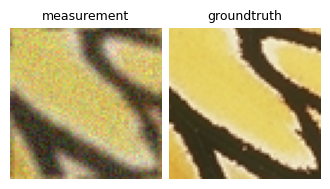

In [5]:
# Plot observations and true x

imgs = [y, x_true]
titles=["measurement", "groundtruth"]
dinv.utils.plotting.plot(
    imgs,
    titles=titles,
)

## Define parameters and initialise model

In [6]:

# y
# physics
# denoising_model
# LikeliL
# params
# options
# diff_params
# device

# Options dictionary associated with the overall sampling algorithm
options = {
    'samplesL': 1e1,        # Number of live samples
    'samplesD': 2e1,      # Number of discarded samples 
       'sigma': sigma,      # Noise standard deviation of degraded image
        'tol' : 1e-6,      # Convergence tolerance of algorithm (Ball projection alg)
   'max_iter' : 200,        # Maximum number of iterations (Ball projection alg)
    'verbose' : True,       # Verbosity
}

diff_params = {
         'model_type' : 'imagenet',     # Type of pretrained model. Options are 'imagenet' or 'ffhq'
        'in_channels' : 3,              # Channels in the input Tensor.
       'out_channels' : 3,              # Channels in the output Tensor.
        'sigma_noise' : sigma,          # Noise standard deviation of degraded image
    'diffusion_steps' : 100,            # Maximum number of iterations of the DiffPIR algorithm
            'lambda_' : 7.0,            # Regularisation parameter
               'zeta' : 0.5,            # DiffPIR parameter controling the diffusion
}


# Gaussian log likelihood
LogLikeliL = lambda x_current, y, physics, sigma : - torch.nn.functional.mse_loss(
    y,
    physics.A(x_current), # Apply the forward model (without the noise addition)
    reduction='sum'
) / (2*sigma**2)

LikeliL = LogLikeliL

# Load the denoiser for the diffusion model 
if diff_params['model_type'] == 'imagenet':
    model_path = "/disk/xray99/tl3/pretrained_diffusions/diffpir_pretrained_models/256x256_diffusion_uncond.pt"
    large_model = True
elif diff_params['model_type'] == 'ffhq':
    model_path = "/disk/xray99/tl3/pretrained_diffusions/diffpir_pretrained_models/diffusion_ffhq_10m.pt"
    large_model = False

denoising_model = dinv.models.DiffUNet(
    in_channels=diff_params['in_channels'],
    out_channels=diff_params['out_channels'],
    pretrained=model_path,
    large_model=large_model
).to(device)



# params_DnCNN = utils.create_parameters_dict(
#            y = np.copy(y),           # Measurements i.e. data
#          Phi = phi,                  # Forward model
#      epsilon = 1e-3,                 # Radius of L2-ball of likelihood 
#        tight = False,                # Is Phi a tight frame or not?
#           nu = 1,                    # Bound on the squared-norm of Phi
#          tol = 1e-10,                # Convergence tolerance of algorithm
#     max_iter = 200,                  # Maximum number of iterations
#      verbose = 0,                    # Verbosity level
#            u = 0,                    # Initial vector for the dual problem
#          pos = True,                 # Positivity flag
#      reality = True                  # Reality flag
# )
    # params = {}
    # params["y"] = y
    # params["Phi"] = Phi
    # params["Psi"] = Psi
    # params["epsilon"] = epsilon
    # params["tight"] = tight
    # params["nu"] = nu
    # params["tol"] = tol
    # params["max_iter"] = int(max_iter)
    # params["verbose"] = verbose
    # params["u"] = u
    # params["pos"] = pos
    # params["reality"] = reality
    # params["l1weights"] = l1weights
    # params["rel_obj"] = rel_obj


In [7]:

# Set initial state as current state
x_init = physics.A_adjoint(y)
Xcur = x_init
tau_0 = -LogLikeliL(Xcur, y, physics, sigma).cpu().numpy() * 1e-1



In [8]:
class DummyDataFidelity(torch.nn.Module):
    def __init__(self):
        a = 1

    def prox(self, x, y=None, physics=None, gamma=None):
        return x


In [9]:
Xcur[0].shape

torch.Size([3, 64, 64])

In [10]:

# Initialise arrays to store samples
# Indexing: sample, likelihood, weights
NumLiveSetSamples = int(options["samplesL"])
NumDiscardSamples = int(options["samplesD"])

# Placeholder for Bayesian evidence
BayEvi = np.zeros(2)

Xtrace = {}

# torch images are (1 x C x H x W)
Xtrace["LiveSet"] = torch.zeros(
    (NumLiveSetSamples, 1, Xcur.shape[1], Xcur.shape[2], Xcur.shape[3]), # Batch x 1 x Channels x Heigth x Width
    dtype=Xcur.dtype,
    device=device,
    requires_grad=False
)
Xtrace["LiveSetL"] = np.zeros(NumLiveSetSamples)

Xtrace["Discard"] = torch.zeros(
    (NumDiscardSamples, 1, Xcur.shape[1], Xcur.shape[2], Xcur.shape[3]), # Batch x 1 x Channels x Heigth x Width
    dtype=Xcur.dtype,
    device=device,
    requires_grad=False
)
Xtrace["DiscardL"] = np.zeros(NumDiscardSamples)
Xtrace["DiscardW"] = np.zeros(NumDiscardSamples)
Xtrace["DiscardPostProb"] = np.zeros(NumDiscardSamples)

# Build prior sampler
prior_sampler = dinv.sampling.DiffPIR(
    denoising_model,
    sigma=diff_params['sigma_noise'],
    max_iter=diff_params['diffusion_steps'],
    lambda_=diff_params['lambda_'],
    zeta=diff_params['zeta'], # 0.5,
    data_fidelity=DummyDataFidelity(),
    verbose=options['verbose'],
    device=device
)
# How to sample from the prior
# xhat =  prior_sampler.forward(y, physics, x_init)

# Build constrained prior sampler
constrained_prior_sampler = dinv.sampling.DiffPIR(
    denoising_model,
    sigma=diff_params['sigma_noise'],
    max_iter=diff_params['diffusion_steps'],
    lambda_=diff_params['lambda_'],
    zeta=diff_params['zeta'], # 0.5,
    data_fidelity=dinv.optim.data_fidelity.IndicatorL2(
        radius=(np.sqrt(
            tau_0 * 2 * diff_params['sigma_noise']**2
        ))
    ),
    verbose=options['verbose'],
    device=device
)


## Init samples

In [11]:

# Obtain samples from priors
for j in tqdm(range(NumLiveSetSamples), desc="DiffNest || Populate"):
    with torch.no_grad():
        # Sample from the prior to generate live samples
        Xcur = prior_sampler.forward(
            y, physics, x_init=x_init
        )
        # Record the current sample in the live set and its likelihood
        Xtrace["LiveSet"][j] = Xcur.clone()
        Xtrace["LiveSetL"][j] = LikeliL(
            Xcur, y, physics, diff_params['diffusion_steps']
        ).detach().cpu().numpy()



DiffNest || Populate: 100%|██████████| 10/10 [00:29<00:00,  2.93s/it]


In [12]:
Xtrace["LiveSet"].shape

torch.Size([10, 1, 3, 64, 64])

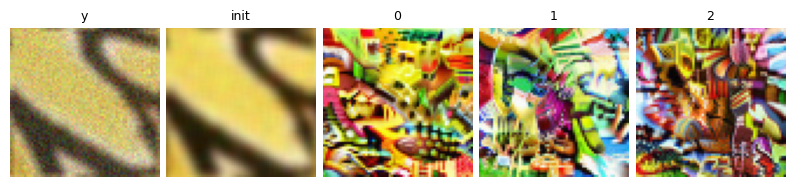

In [13]:

imgs = [y, x_init, Xtrace["LiveSet"][0], Xtrace["LiveSet"][1], Xtrace["LiveSet"][2]]
titles=["y", "init","0", "1", "2"]
dinv.utils.plotting.plot(
    imgs,
    titles=titles,
)


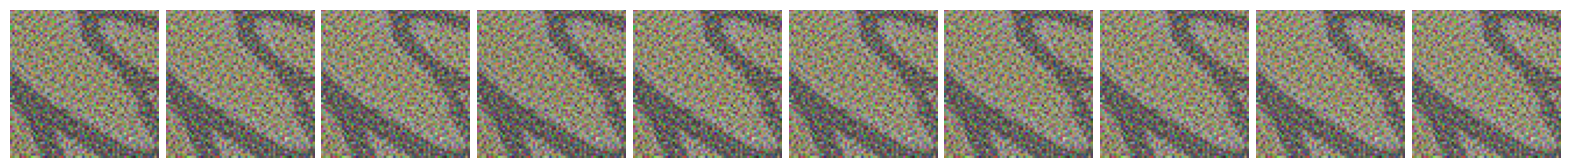

In [28]:

imgs = [_x for _x in Xtrace["LiveSet"]]
dinv.utils.plotting.plot(
    imgs,
    # titles=titles,
)





## Update samples

In [14]:
np.argmin(Xtrace["LiveSetL"])
example = Xtrace["LiveSet"][np.argmin(Xtrace["LiveSetL"])].clone()

In [15]:
def reorder_samples(samples, likelihood_values):
    r"""This program is to find the sample with the smallest likelihood and move it to the end of the list

    Args:
        samples (np.ndarray): given sample list
        likeliVal (np.ndarray): corresponding likelihood

    Returns:
        tuple: Reordered version of (samples, likelihood_values)

    Notes:
        MATLAB version: Xiaohao Cai (30/01/2019)
        Python version: Matthew Price (10/05/2022)
    """

    # find the smallest likelihood and corresponding index
    minSamIdx = np.argmin(likelihood_values)

    # swap the sample wit the smallest likelihood to the end of the list
    if torch.is_tensor(samples[0]):
        tempSample = samples[minSamIdx].clone()
        samples[minSamIdx] = samples[-1].clone()
        samples[-1] = tempSample
    else:
        tempSample = samples[minSamIdx]
        samples[minSamIdx] = samples[-1]
        samples[-1] = tempSample

    # swap the likelihood accordingly
    tempL = likelihood_values[minSamIdx]
    likelihood_values[minSamIdx] = likelihood_values[-1]
    likelihood_values[-1] = tempL

    return samples, likelihood_values


In [16]:
Xtrace["LiveSet"], Xtrace["LiveSetL"] = reorder_samples(
    Xtrace["LiveSet"], Xtrace["LiveSetL"]
)

/disk/xray0/tl3/miniconda3/envs/nest_diff/lib/python3.9/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


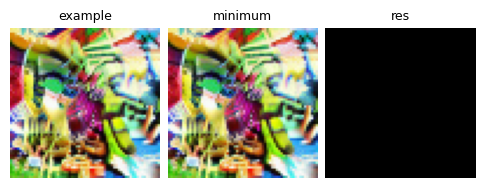

In [17]:

imgs = [example, Xtrace["LiveSet"][-1], example-Xtrace["LiveSet"][-1]]
titles=["example", "minimum", "res"]
dinv.utils.plotting.plot(
    imgs,
    titles=titles,
)





In [18]:
y.dtype

torch.float32

In [19]:
Xcur.dtype

torch.float32

In [20]:


# Update samples using the proximal nested sampling technique
for k in tqdm(range(NumDiscardSamples), desc="DiffNest || Sample"):
    with torch.no_grad():
        # Reorder samples TODO: Make this more efficient!
        Xtrace["LiveSet"], Xtrace["LiveSetL"] = reorder_samples(
            Xtrace["LiveSet"], Xtrace["LiveSetL"]
        )

        # Compute the smallest threshold wrt live samples' likelihood
        tau = -Xtrace["LiveSetL"][-1]  # - 1e-2

        # Randomly select a sample in the live set as a starting point
        indNewSample = (
            np.floor(np.random.rand() * (NumLiveSetSamples - 1)).astype(int) - 1
        )
        Xcur = Xtrace["LiveSet"][indNewSample]

        # Update likelihood constraint
        # update_likelihood_constraint(tau)
        constrained_prior_sampler = dinv.sampling.DiffPIR(
            denoising_model,
            sigma=diff_params['sigma_noise'],
            max_iter=diff_params['diffusion_steps'],
            lambda_=diff_params['lambda_'],
            zeta=diff_params['zeta'],
            data_fidelity=dinv.optim.data_fidelity.IndicatorL2(
                radius=(np.sqrt(
                    tau * 2 * diff_params['sigma_noise']**2
                )).astype(np.float32)
            ),
            verbose=options['verbose'],
            device=device
        )

        # Sample from the constrained prior
        Xcur = constrained_prior_sampler.forward(
            y, physics, x_init=Xcur
        )

        # check if the new sample is inside l2-ball (metropolis-hasting); if
        # not, force the new sample into L2-ball
        if torch.nn.functional.mse_loss(
            y, physics.A(Xcur), reduction='sum'
        ) > (
            tau * 2 * diff_params['sigma_noise']**2
        ):
            print('Explicitly enforcing L2 ball in MH step.')
            indicatorL2 = dinv.optim.data_fidelity.IndicatorL2(
                radius=np.sqrt(
                    tau * 2 * diff_params['sigma_noise']**2
                ).astype(np.float32)
            )
            Xcur = indicatorL2.prox(
                x=Xcur,
                y=y,
                physics=physics,
                crit_conv=options['tol'],
                max_iter=options['max_iter'],
            )


        # Record the sample discarded and its likelihood
        Xtrace["Discard"][k] = Xtrace["LiveSet"][-1].clone()
        Xtrace["DiscardL"][k] = Xtrace["LiveSetL"][-1].copy()

        # Add the new sample to the live set and its likelihood
        Xtrace["LiveSet"][-1] = Xcur.clone()
        Xtrace["LiveSetL"][-1] = LikeliL(
            Xcur, y, physics, diff_params['diffusion_steps']
        ).detach().cpu().numpy()


# Reorder the live samples TODO: Make this more efficient!
Xtrace["LiveSet"], Xtrace["LiveSetL"] = reorder_samples(
    Xtrace["LiveSet"], Xtrace["LiveSetL"]
)



DiffNest || Sample:   5%|▌         | 1/20 [00:11<03:39, 11.54s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  10%|█         | 2/20 [00:23<03:27, 11.54s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  15%|█▌        | 3/20 [00:34<03:16, 11.54s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  20%|██        | 4/20 [00:46<03:04, 11.54s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  25%|██▌       | 5/20 [00:57<02:52, 11.52s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  30%|███       | 6/20 [01:09<02:40, 11.49s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  35%|███▌      | 7/20 [01:20<02:29, 11.47s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  40%|████      | 8/20 [01:31<02:17, 11.47s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  45%|████▌     | 9/20 [01:43<02:06, 11.49s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  50%|█████     | 10/20 [01:54<01:54, 11.49s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  55%|█████▌    | 11/20 [02:06<01:43, 11.48s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  60%|██████    | 12/20 [02:17<01:31, 11.48s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  65%|██████▌   | 13/20 [02:29<01:20, 11.48s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  70%|███████   | 14/20 [02:40<01:08, 11.48s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  75%|███████▌  | 15/20 [02:52<00:57, 11.49s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  80%|████████  | 16/20 [03:03<00:45, 11.49s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  85%|████████▌ | 17/20 [03:15<00:34, 11.50s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  90%|█████████ | 18/20 [03:26<00:23, 11.50s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample:  95%|█████████▌| 19/20 [03:38<00:11, 11.50s/it]

Enforcing L2 ball in MH step.


DiffNest || Sample: 100%|██████████| 20/20 [03:49<00:00, 11.50s/it]

Enforcing L2 ball in MH step.


## Compute evidence and statistics

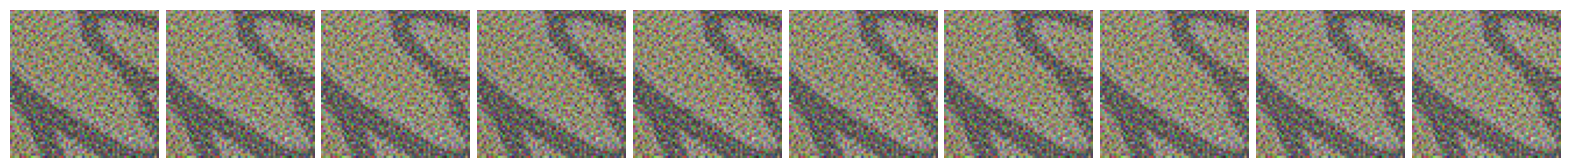

In [27]:

imgs = [_x for _x in Xtrace["LiveSet"]]
titles=["GT", "post mean", "res"]
dinv.utils.plotting.plot(
    imgs,
    # titles=titles,
)


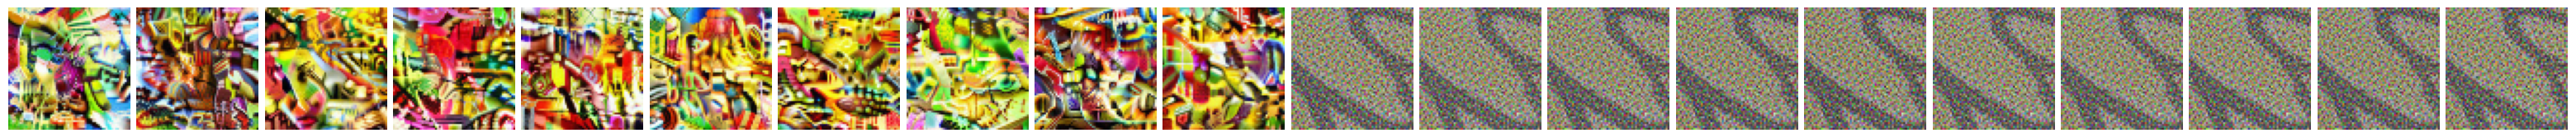

In [29]:

imgs = [_x for _x in Xtrace["Discard"]]
titles=["GT", "post mean", "res"]
dinv.utils.plotting.plot(
    imgs,
    # titles=titles,
)


In [21]:

BayEvi = np.zeros(2)
Xtrace["DiscardW"][0] = 1 / NumLiveSetSamples

# Compute the sample weight
for k in tqdm(range(NumDiscardSamples), desc="DiffNest || Compute Weights"):
    Xtrace["DiscardW"][k] = np.exp(-(k + 1) / NumLiveSetSamples)

# Compute the volumn length for each sample using trapezium rule
discardLen = np.zeros(NumDiscardSamples)
discardLen[0] = (1 - np.exp(-2 / NumLiveSetSamples)) / 2

for i in tqdm(
    range(1, NumDiscardSamples - 1), desc="DiffNest || Trapezium Integrate"
):
    discardLen[i] = (Xtrace["DiscardW"][i - 1] - Xtrace["DiscardW"][i + 1]) / 2

discardLen[-1] = (
    np.exp(-(NumDiscardSamples - 1) / NumLiveSetSamples)
    - np.exp(-(NumDiscardSamples + 1) / NumLiveSetSamples)
) / 2
# volume length of the last discarded sample

liveSampleLen = np.exp(-(NumDiscardSamples) / NumLiveSetSamples)
# volume length of the living sample

# Apply the disgarded sample for Bayesian evidence value computation
vecDiscardLLen = Xtrace["DiscardL"] + np.log(discardLen)

# Apply the final live set samples for Bayesian evidence value computation
vecLiveSetLLen = Xtrace["LiveSetL"] + np.log(liveSampleLen / NumLiveSetSamples)

# #   ------- Way 1: using discarded and living samples --------
# # Get the maximum value of the exponents for all the samples
# maxAllSampleLLen = max(max(vecDiscardLLen),max(vecLiveSetLLen))

# # Compute the Bayesian evidence value using discarded and living samples
# BayEvi[0] = maxAllSampleLLen + np.log(np.sum(np.exp(vecDiscardLLen-maxAllSampleLLen)) + np.sum(np.exp(vecLiveSetLLen-maxAllSampleLLen)))

# ------- Way 2: using discarded samples --------
# Get the maximum value of the exponents for the discarded samples
maxDiscardLLen = np.max(vecDiscardLLen)

# Compute the Bayesian evidence value using discarded and living samples
BayEvi[0] = maxDiscardLLen + np.log(np.sum(np.exp(vecDiscardLLen - maxDiscardLLen)))

# Extimate the error of the computed Bayesian evidence
entropyH = 0

for k in tqdm(range(NumDiscardSamples), desc="ProxNest || Estimate Variance"):
    temp1 = np.exp(Xtrace["DiscardL"][k] + np.log(discardLen[k]) - BayEvi[0])
    entropyH = entropyH + temp1 * (Xtrace["DiscardL"][k] - BayEvi[0])

# Evaluate the evidence variance
BayEvi[1] = np.sqrt(np.abs(entropyH) / NumLiveSetSamples)

# Compute the posterior probability for each discarded sample
for k in tqdm(range(NumDiscardSamples), desc="ProxNest || Compute Posterior Mean"):
    Xtrace["DiscardPostProb"][k] = np.exp(
        Xtrace["DiscardL"][k] + np.log(discardLen[k]) - BayEvi[0]
    )

# Compute the posterior mean of the discarded samples -- optimal solution
Xtrace["DiscardPostMean"] = torch.zeros(
    (
        1,
        Xcur.shape[1],
        Xcur.shape[2],
        Xcur.shape[3]
    ), # 1 x Channels x Heigth x Width
    dtype=Xcur.dtype,
    device=device,
    requires_grad=False
)

for k in range(NumDiscardSamples):
    Xtrace["DiscardPostMean"] = Xtrace["DiscardPostMean"] + Xtrace["DiscardPostProb"][k] * Xtrace["Discard"][k].clone()




DiffNest || Compute Weights: 100%|██████████| 20/20 [00:00<00:00, 224895.66it/s]
DiffNest || Trapezium Integrate: 100%|██████████| 18/18 [00:00<00:00, 317216.27it/s]
ProxNest || Estimate Variance: 100%|██████████| 20/20 [00:00<00:00, 173318.35it/s]
ProxNest || Compute Posterior Mean: 100%|██████████| 20/20 [00:00<00:00, 225500.22it/s]


In [22]:

Xtrace["DiscardPostMean"].shape


torch.Size([1, 3, 64, 64])

In [25]:
BayEvi

array([-0.23572796,  0.13945929])

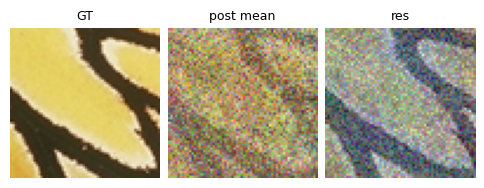

In [26]:

imgs = [x_true, Xtrace["DiscardPostMean"], x_true-Xtrace["DiscardPostMean"]]
titles=["GT", "post mean", "res"]
dinv.utils.plotting.plot(
    imgs,
    titles=titles,
)
